# 0. Data 📦

In [1]:
# Import packages
import pandas as pd
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
import helpers # custom module
# Update default settings
pd.options.display.float_format = '{:.4f}'.format
sns.set(style='darkgrid', context='talk', palette='Set1')

In [2]:
%matplotlib inline

In [3]:
# Import data
exclude = ['pclass', 'embarked', 'who', 'adult_male', 'alive', 'alone']
df = sns.load_dataset('titanic').drop(columns=exclude)
# Inspect shape of the data and top rows
print(f"{df.shape[0]} rows, {df.shape[1]} columns")
df.head()

891 rows, 9 columns


,survived,sex,age,sibsp,parch,fare,class,deck,embark_town
0,0,male,22.0000,1,0,7.2500,Third,NaN,Southampton
1,1,female,38.0000,1,0,71.2833,First,C,Cherbourg
2,1,female,26.0000,0,0,7.9250,Third,NaN,Southampton
3,1,female,35.0000,1,0,53.1000,First,C,Southampton
4,0,male,35.0000,0,0,8.0500,Third,NaN,Southampton


In [4]:
target = 'survived'
features = df.drop(columns=target).columns

In [5]:
# Split data into train & test
X_train, X_test, y_train, y_test = helpers.partition(df, target)
# Append target back using indices
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)
# Inspect training data
print(f"Training data ({train.shape[0]} rows): Target distribution")
display(helpers.find_frequency(y_train))
print(f"Test data ({test.shape[0]} rows): Target distribution")
display(helpers.find_frequency(y_test))

Training data (712 rows): Target distribution


,p_frequency,n_frequency
0,0.6166,439
1,0.3834,273


Test data (179 rows): Target distribution


,p_frequency,n_frequency
0,0.6145,110
1,0.3855,69


# Step 1: Basic exploration🐇

## Part 1. Leverage automation tool

In [6]:
# Create profile report in html

profile_train = ProfileReport(train, title="Training Data Report", 
                              dark_mode=True)

# Export it to html file
profile_train.to_file("training_data_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
# Create profile report in jupyter notebook

# # Option 1
# train.profile_report()

# # Option 2   --> didn't work for me
# profile = ProfileReport(train)
# profile.to_widgets()

# Option 3
profile = ProfileReport(train)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Part 2. Use custom functions for the remaining basic exploration

In [8]:
helpers.summarise(train)

,n_missing,p_missing,n_unique,dtype
deck,560,0.7865,7,category
age,150,0.2107,83,float64
embark_town,1,0.0014,3,object
sex,0,0.0000,2,object
sibsp,0,0.0000,7,int64
parch,0,0.0000,7,int64
fare,0,0.0000,221,float64
class,0,0.0000,3,category
survived,0,0.0000,2,int64


In [9]:
# Define feature groups
continuous = train[features].select_dtypes(['float']).columns
discrete = train[features].columns.difference(continuous)
# Convert to category dtype
train[discrete] = train[discrete].astype('category')

In [10]:
helpers.describe_more(train, continuous)

,age,fare
count,562.0000,712.0000
mean,29.3117,31.0473
std,14.4750,49.2412
min,0.4200,0.0000
25%,20.0000,7.8958
50%,28.0000,14.4271
75%,38.0000,30.0177
max,80.0000,512.3292
n_outliers,4.0000,87.0000
p_outliers,0.0056,0.1222


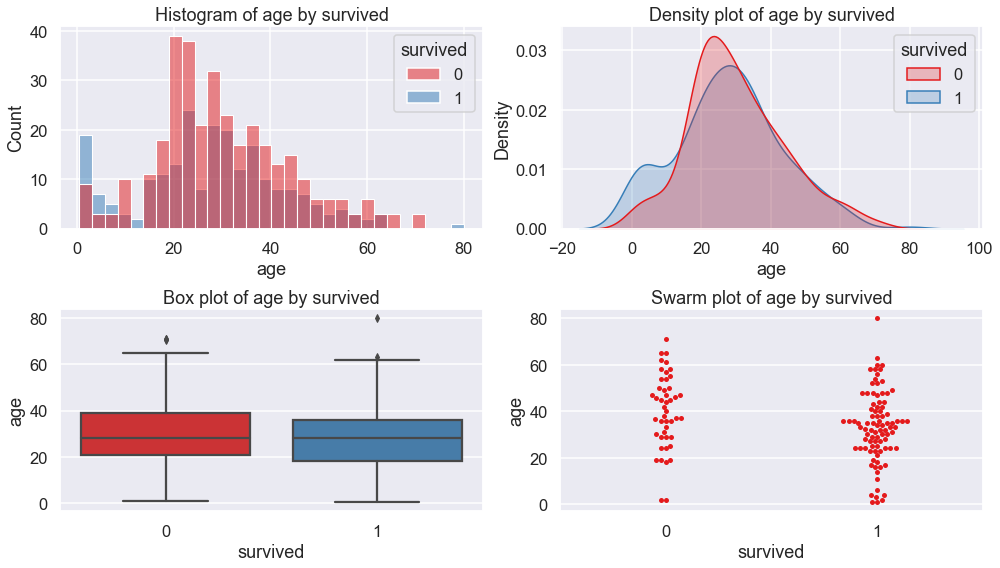

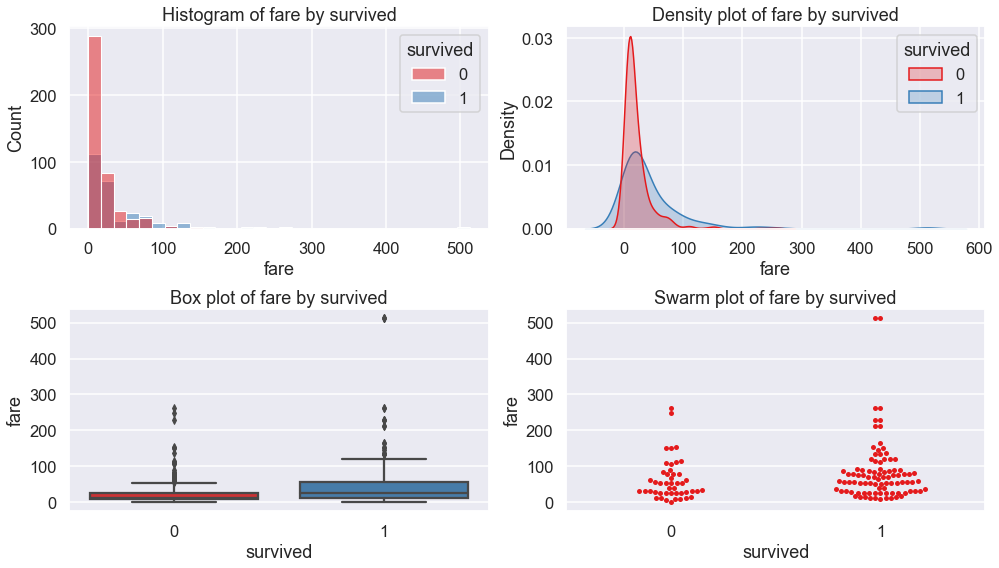

In [11]:
for feature in continuous:
    helpers.plot_continuous(train, feature, target)

#### Similar summaries and visualisations can be done for discrete values:

In [12]:
train.describe(exclude=['number'])

,sex,sibsp,parch,class,deck,embark_town
count,712,712,712,712,152,711
unique,2,7,7,3,7,3
top,male,0,0,Third,C,Southampton
freq,467,486,548,399,46,514


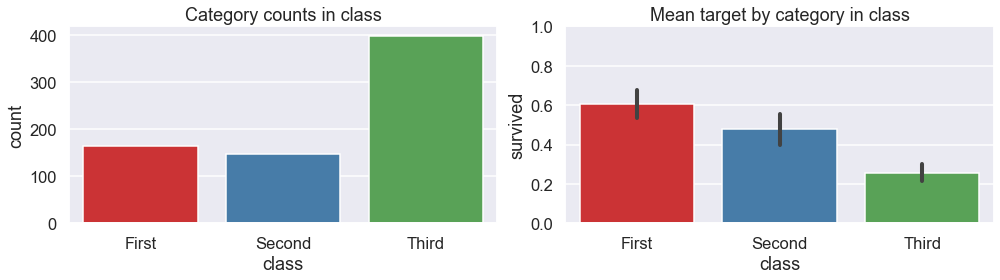

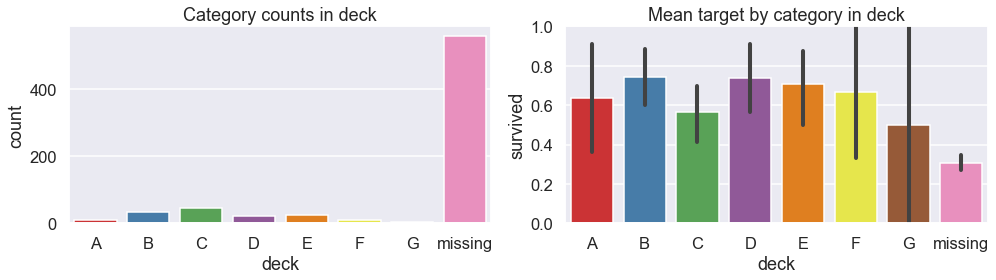

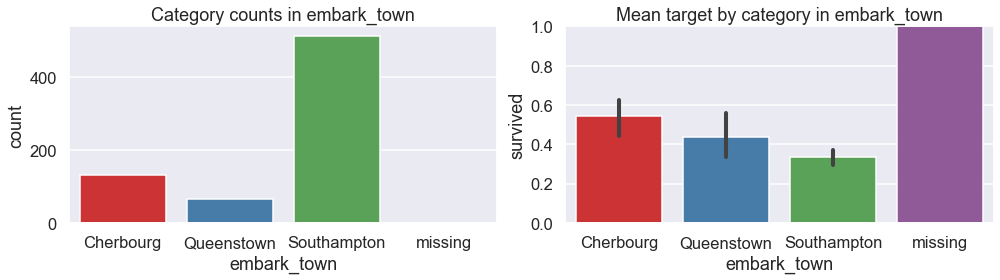

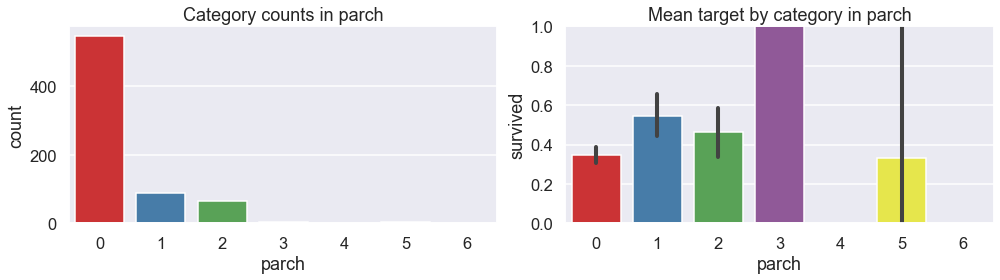

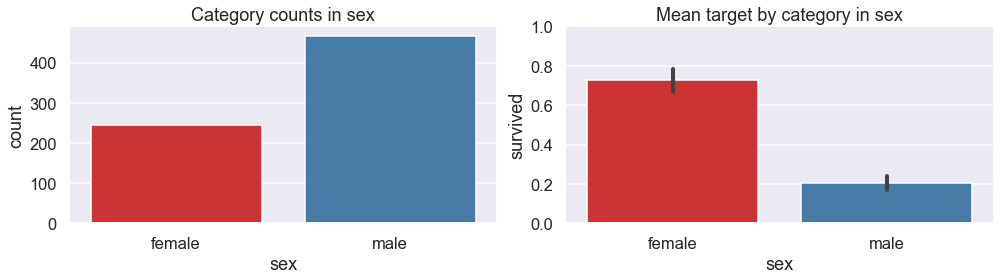

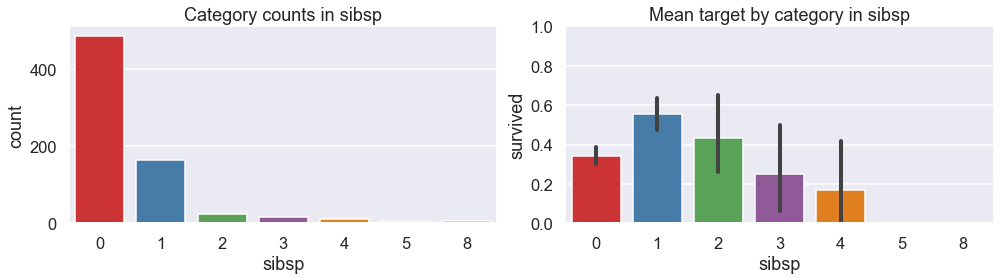

In [13]:
# Fill missing
for feature in discrete:
    if train[feature].isnull().sum() > 0:
        train[feature] = train[feature].cat\
                                       .add_categories('missing')
        train[feature] = train[feature].fillna('missing')
# Visualise
for feature in discrete:
    helpers.plot_discrete(train, feature, target)

# Step 2. Custom exploration 🐢

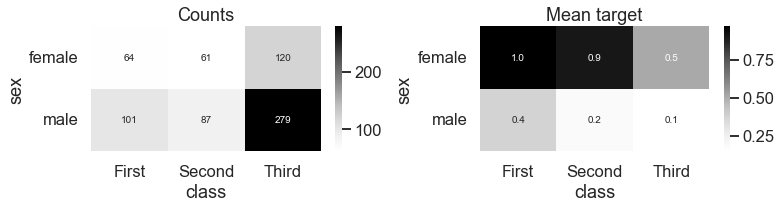

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(11,3))
sns.heatmap(pd.crosstab(train['sex'], train['class']), 
            cmap='Greys', annot=True, fmt='g', ax=ax[0])
ax[0].set_title("Counts")
ax[0].set_yticklabels(ax[0].get_yticklabels(), rotation=0)
sns.heatmap(train.pivot_table(target, 'sex', 'class'), 
            cmap='Greys', annot=True, fmt='.1f', ax=ax[1])
ax[1].set_title("Mean target")
ax[1].set_yticklabels(ax[1].get_yticklabels(), rotation=0)
plt.tight_layout();